In [1]:
from tilebox.datasets import Client as DatasetClient

In [2]:
from sentinel2zarr import RegionOfInterest, AreaOfInterest

In [3]:
aoi = AreaOfInterest(-10.68234795, 51.36473433, -5.94679566, 55.44704815)
smaller_x = 2
smaller_y = 1.8
aoi = AreaOfInterest(-10.68234795 + smaller_x, 51.36473433 + smaller_y, -5.94679566 - smaller_x, 55.44704815 - smaller_y)

In [4]:
aoi.shape.exterior.coords.xy

(array('d', [-7.94679566, -7.94679566, -8.68234795, -8.68234795, -7.94679566]),
 array('d', [53.164734329999995, 53.64704815, 53.64704815, 53.164734329999995, 53.164734329999995]))

In [190]:
gb = aoi.as_geobox("EPSG:2157", 10)

In [192]:
gb.shape


Shape2d(x=4919, y=5389)

In [145]:
roi = RegionOfInterest(aoi, ("2025-01-01", "2025-02-01"))

In [37]:
collection = DatasetClient().dataset("open_data.copernicus.sentinel2_msi").collection("S2A_S2MSI2A")

In [38]:
granules = collection.query(temporal_extent=roi.time, spatial_extent=roi.area.shape)

In [ ]:
"\n".join(granules.location.values)

In [209]:
from obstore.store import S3Store

In [210]:
import obstore.store
from obstore import list_with_delimiter

In [42]:
store = S3Store(
    bucket="eodata",
    access_key_id="NP6EJ5I20KY0XE719YBI",
    secret_access_key="jhwq1D6rzvIz69pyV3A1nVbAakmR1eABMgcTAe8F",
    endpoint="https://eodata.dataspace.copernicus.eu",
)

In [43]:
test = "Sentinel-2/MSI/L2A/2025/01/02/S2A_MSIL2A_20250102T115501_N0511_R023_T28UGB_20250102T144951.SAFE"

In [44]:
from pathlib import Path

In [45]:
product_suffixes = {"B02_10m.jp2", "B03_10m.jp2", "B04_10m.jp2", "SCL_20m.jp2"}

for page in store.list("Sentinel-2/MSI/L2A/2025/01/02/S2A_MSIL2A_20250102T115501_N0511_R023_T28UGB_20250102T144951.SAFE"):
    for obj in page:
        product = obj["path"]
        if any(product.endswith(suffix) for suffix in product_suffixes):
            print(product)

Sentinel-2/MSI/L2A/2025/01/02/S2A_MSIL2A_20250102T115501_N0511_R023_T28UGB_20250102T144951.SAFE/GRANULE/L2A_T28UGB_A049784_20250102T115504/IMG_DATA/R10m/T28UGB_20250102T115501_B02_10m.jp2
Sentinel-2/MSI/L2A/2025/01/02/S2A_MSIL2A_20250102T115501_N0511_R023_T28UGB_20250102T144951.SAFE/GRANULE/L2A_T28UGB_A049784_20250102T115504/IMG_DATA/R10m/T28UGB_20250102T115501_B03_10m.jp2
Sentinel-2/MSI/L2A/2025/01/02/S2A_MSIL2A_20250102T115501_N0511_R023_T28UGB_20250102T144951.SAFE/GRANULE/L2A_T28UGB_A049784_20250102T115504/IMG_DATA/R10m/T28UGB_20250102T115501_B04_10m.jp2
Sentinel-2/MSI/L2A/2025/01/02/S2A_MSIL2A_20250102T115501_N0511_R023_T28UGB_20250102T144951.SAFE/GRANULE/L2A_T28UGB_A049784_20250102T115504/IMG_DATA/R20m/T28UGB_20250102T115501_SCL_20m.jp2


In [46]:
data = store.get("Sentinel-2/MSI/L2A/2025/01/02/S2A_MSIL2A_20250102T115501_N0511_R023_T28UGB_20250102T144951.SAFE/GRANULE/L2A_T28UGB_A049784_20250102T115504/IMG_DATA/R10m/T28UGB_20250102T115501_B02_10m.jp2")

In [47]:
data = data.bytes()

In [48]:
len(data) / 1024 / 1024

104.59062671661377

In [49]:
import rasterio

In [50]:
from rasterio import MemoryFile

In [58]:
from io import BytesIO

In [59]:
buffer = BytesIO()

In [60]:
buffer.write(data)

109671221

In [74]:
r = obstore.open_reader(store, "Sentinel-2/MSI/L2A/2025/01/02/S2A_MSIL2A_20250102T115501_N0511_R023_T28UGB_20250102T144951.SAFE/GRANULE/L2A_T28UGB_A049784_20250102T115504/IMG_DATA/R10m/T28UGB_20250102T115501_B02_10m.jp2")

In [76]:
with rasterio.open(r, driver="JP2OpenJPEG") as rr:
    arr = rr.read(1)

TypeError: Constructor argument must be a file opened in binary mode or bytes.

In [ ]:
del arr

In [70]:
with rasterio.open(buffer, driver="JP2OpenJPEG") as r:
    arr = r.read(1)

In [71]:
arr.shape

(10980, 10980)

In [66]:
arr = r.read(1)

In [69]:
arr.shape

(10980, 10980)

In [24]:
with f.open():
    f.write(data)

ValueError: 'driver' is required to read/write dataset.

In [132]:


rasterio.open()

TypeError: invalid path or file: <builtins.GetResult object at 0x115cb5610>

In [211]:
_PRODUCT_SUFFIXES = {"B02_10m.jp2", "B03_10m.jp2", "B04_10m.jp2", "SCL_20m.jp2"}

In [219]:
import pickle
from dataclasses import dataclass
from functools import lru_cache
from io import BytesIO
from pathlib import Path

import dask.array
import numpy as np
import rasterio
from boto3 import Session
import xarray as xr
from obstore.store import LocalStore, ObjectStore, S3Store
from odc.geo.geobox import GeoBox
from odc.geo.xr import wrap_xr
from pyproj import Transformer
from rasterio.enums import Resampling
from shapely import Polygon, box, transform
from tilebox.datasets import Client as DatasetClient
from tilebox.datasets.data.time_interval import TimeInterval
from tilebox.workflows import ExecutionContext, Task
from zarr.storage import ObjectStore as ZarrObjectStore
from sentinel2zarr import zarr_storage

In [213]:
_PRODUCT_SUFFIXES = {"B02_10m.jp2", "B03_10m.jp2", "B04_10m.jp2", "SCL_20m.jp2"}

In [215]:
zarr_store = ZarrObjectStore()

In [244]:
s3_store = S3Store(bucket="workflow-cache-35ee674", prefix="s2-zarr/dummy/cube", 
            region="eu-central-1",
            credential_provider=Boto3CredentialProvider(Session(profile_name="default")))

In [245]:
zarr_store = ZarrObjectStore(s3_store)

In [246]:
dataset = xr.Dataset()
for product in _PRODUCT_SUFFIXES:
    variable_name = Path(product).stem.split("_")[-2]  # B02, B03, B04 or SCL
    dataset[variable_name] = (
        ["time", "y", "x"],
        dask.array.zeros((12, gb.shape.y, gb.shape.x), chunks=(1, 4096, 4096), dtype=np.uint16),
    )

#zarr_store = ZarrObjectStore(zarr_storage("s2-zarr/dummy/cube"))
dataset.to_zarr(zarr_store, compute=False, mode="w", consolidated=False, zarr_format=3)

Delayed('_finalize_store-f61d89c0-56a8-4266-9111-107b643833e9')

In [29]:
import boto3

In [32]:
boto3.Session(profile_name="copernicus-dataspace")

Session(region_name=None)

In [47]:
import pickle
from dataclasses import dataclass
from functools import lru_cache
from io import BytesIO
from pathlib import Path

import dask.array
import numpy as np
import rasterio
import xarray as xr
from boto3 import Session
from obstore.auth.boto3 import Boto3CredentialProvider
from obstore.store import GCSStore, LocalStore, ObjectStore, S3Store
from odc.geo.geobox import GeoBox
from odc.geo.xr import wrap_xr
from pyproj import Transformer
from rasterio.enums import Resampling
from shapely import Polygon, box, transform
from tilebox.datasets import Client as DatasetClient
from tilebox.datasets.data.time_interval import TimeInterval
from tilebox.workflows import ExecutionContext, Task
from zarr.storage import ObjectStore as ZarrObjectStore

_PRODUCT_SUFFIXES = {"B02_10m.jp2", "B03_10m.jp2", "B04_10m.jp2", "SCL_20m.jp2"}
"""Name suffixes of the Sentinel-2 products we are interested in for each granule"""


@lru_cache
def sentinel2_data_store() -> ObjectStore:
    """An object store for reading the input Sentinel-2 data from

    Running on a CloudFerro VM, the full Copernicus archive is mounted as /eodata. Otherwise, we access it via S3,
    using credentials generated via https://eodata-s3keysmanager.dataspace.copernicus.eu/
    """
    eodata_mounted = Path("/eodata")  # on CloudFerro, the copernicus bucket is mounted as /eodata
    if eodata_mounted.exists():
        return LocalStore(eodata_mounted)

    # to access the Copernicus S3 bucket directly, generate credentials via
    # https://eodata-s3keysmanager.dataspace.copernicus.eu/ and then add them as a `copernicus-dataspace` profile in
    # ~/.aws/credentials

    return S3Store(
        bucket="eodata",
        endpoint="https://eodata.dataspace.copernicus.eu",
        credential_provider=Boto3CredentialProvider(Session(profile_name="copernicus-dataspace")),
    )


In [24]:
test = xr.open_zarr(zarr_store, consolidated=False, zarr_format=3)

In [155]:
from tilebox.datasets import Client

In [156]:
coll = Client().dataset("open_data.copernicus.sentinel2_msi").collection("S2A_S2MSI2A")

In [ ]:
coll.query(
    temporal_extent=("2025-05-01", "2025-05-09"),
    spatial_extent=aoi.shape
)

In [397]:
from tilebox.workflows import Client as WorkflowsClient
from sentinel2zarr import Sentinel2ToZarr, RegionOfInterest

In [418]:
c = WorkflowsClient()

In [419]:
job = c.jobs().submit(
    "s2-ireland-test-small",
    Sentinel2ToZarr(
        "S2A_S2MSI2A",
        RegionOfInterest(aoi, ("2025-05-01", "2025-05-09")),
        "EPSG:2157",
        10
    ),
    "workflows-demo-7GzWwLrcvfJ8xZ"
)

In [445]:
c.jobs().display(job)

In [347]:
from io import BytesIO

In [384]:
from base64 import b64encode

In [389]:
b64encode("test".encode()).decode()

'dGVzdA=='

In [390]:
import pickle

In [396]:
b64encode(pickle.dumps(gb))

b'gASVDwEAAAAAAACMDm9kYy5nZW8uZ2VvYm94lIwGR2VvQm94lJOUKYGUTn2UKIwGX3NoYXBllIwNb2RjLmdlby50eXBlc5SMB1NoYXBlMmSUk5QpgZROfZSMA194eZRNNxNNDRWGlHOGlGKMB19hZmZpbmWUjAZhZmZpbmWUjAZBZmZpbmWUk5QoR0AkAAAAAAAARwAAAAAAAAAAR0Eg6wQAAAAARwAAAAAAAAAAR8AkAAAAAAAAR0EnZOgAAAAAdJSBlIwEX2Nyc5SMC29kYy5nZW8uY3JzlIwDQ1JTlJOUKYGUfZSMB2Nyc19zdHKUjAlFUFNHOjIxNTeUc2KMB19leHRlbnSUTowIX2xhenlfdWmUTnWGlGIu'

In [380]:
with BytesIO() as test:
    test.write(b"asdf")
    print(test.getvalue())

b'asdf'


In [376]:
test.getbuffer()

ValueError: I/O operation on closed file.

In [357]:
b.close()

In [368]:
bytes(b)

b''

In [ ]:
from sentinel2zarr import 

In [381]:
c.jobs().retry(job)

1

In [282]:
from sentinel2zarr import Sentinel2ToZarr, RegionOfInterest, zarr_storage, _PRODUCT_SUFFIXES, sentinel2_data_store
from sentinel2zarr import *

In [284]:
product_location = "Sentinel-2/MSI/L2A/2025/05/01/S2A_MSIL2A_20250501T114401_N0511_R123_T29UNV_20250501T193303.SAFE/GRANULE/L2A_T29UNV_A051486_20250501T114459/IMG_DATA/R10m/T29UNV_20250501T114401_B02_10m.jp2"

In [300]:
variable_name = Path(product_location).stem.split("_")[-2]  # B02, B03, B04 or SCL

In [286]:
buffer = BytesIO()
# read the product from object store / local file system
for chunk in sentinel2_data_store().get(product_location):
    buffer.write(chunk)

In [311]:
with rasterio.open(buffer) as product:
    arr = product.read(1)
    src_grid = GeoBox(shape=arr.shape, affine=product.transform, crs=product.crs)

In [304]:
arr

array([[2912, 3074, 3014, ..., 9832, 9800, 9760],
       [2802, 2886, 2764, ..., 9728, 9744, 9792],
       [2714, 2778, 2700, ..., 9712, 9784, 9896],
       ...,
       [4904, 5016, 5124, ..., 8792, 8720, 8680],
       [4828, 4936, 5004, ..., 8784, 8720, 8608],
       [4644, 4808, 4896, ..., 8688, 8616, 8544]],
      shape=(10980, 10980), dtype=uint16)

In [306]:
dataset = xr.Dataset({variable_name: (["y", "x"], arr)})
dataset[variable_name] = wrap_xr(dataset[variable_name], gbox=src_grid)  # add source spatial_ref metadata

In [307]:
target_grid = aoi.as_geobox("EPSG:2157", 10)

In [251]:
target_dataset= dataset.odc.reproject(how=target_grid, resampling=Resampling.nearest, dst_nodata=0)

In [203]:
zarr_prefix = f"s2-zarr/dummy/cube"  # type: ignore[attr-defined]

In [204]:
zarr_store = ZarrObjectStore(zarr_storage(zarr_prefix))

In [253]:
target_dataset = target_dataset.expand_dims(time=1)

In [254]:
target_dataset = target_dataset.drop_vars("spatial_ref")

In [255]:
target_dataset[variable_name] = target_dataset[variable_name].chunk({"time": 1, "y": 4096, "x": 4096})

In [256]:
target_dataset.to_zarr(
    zarr_store,
    region={
        "time": slice(1, 1 + 1),
        "y": slice(0, target_grid.shape.y),
        "x": slice(0, target_grid.shape.x),
    },
    consolidated=False,
    write_empty_chunks=False,
    zarr_format=3,
    safe_chunks=False,
)

In [258]:
import matplotlib.pyplot as plt

In [259]:
plt.imshow(target_dataset.B02.values[0], interpolation="none")

AttributeError: 'Dataset' object has no attribute 'B02'

In [148]:
target_dataset.B02.sum().compute()

<xarray.DataArray 'B02' ()> Size: 8B
array(39384477575, dtype=uint64)

In [572]:
from sentinel2zarr import zarr_storage, ZarrObjectStore

In [573]:
@lru_cache
def zarr_storage(prefix: str) -> ObjectStore:
    """An object store for writing the output Zarr datacube to"""
    return S3Store(
        bucket=ZARR_S3_BUCKET,
        region="eu-central-1",
        prefix=prefix,
        credential_provider=Boto3CredentialProvider(Session(profile_name="default")),
    )

In [574]:
s3_bucket = zarr_storage("s2-zarr/01970d35-ad4a-f107-d7ff-361da09ecc2a/cube")

In [575]:
bla = xr.open_zarr(ZarrObjectStore(s3_bucket), zarr_format=3, consolidated=False)

In [492]:
b02 = bla.B02.where(bla.B02 != 0).quantile(0.5, dim="time").compute()

In [493]:
b03 = bla.B03.where(bla.B03 != 0).quantile(0.5, dim="time").compute()

In [494]:
b04 = bla.B04.where(bla.B04 != 0).quantile(0.5, dim="time").compute()

In [495]:
import numpy as np

In [529]:
def to_0_1(arr, clip_percentile=10):
    min_val = np.percentile(arr, clip_percentile)
    max_val = np.percentile(arr, 100 - clip_percentile)
    arr = np.clip(arr, min_val, max_val)
    return (arr - min_val) / (max_val - min_val)

In [497]:
rgb = np.stack([to_0_1(b04), to_0_1(b03), to_0_1(b02)])

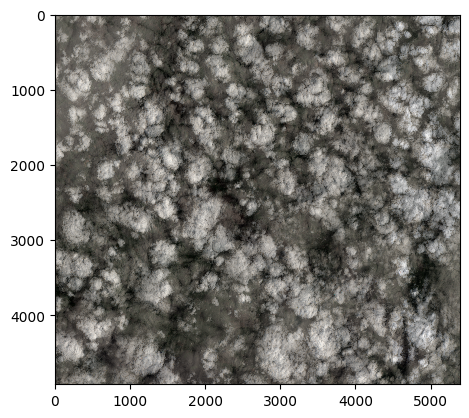

In [498]:
plt.imshow(rgb.T, interpolation="none")

In [556]:
b02 = bla.B02.isel(time=3).compute()

In [557]:
b03 = bla.B03.isel(time=3).compute()

In [558]:
b04 = bla.B04.isel(time=3).compute()

In [568]:
scl = bla.SCL.isel(time=3).compute()

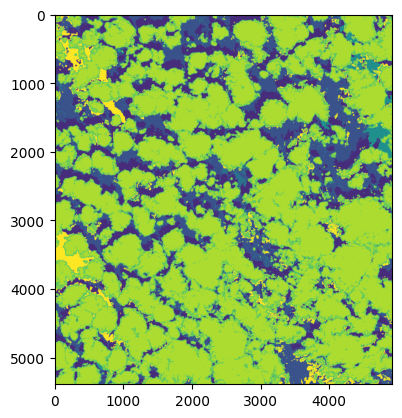

In [569]:
plt.imshow(scl)

In [559]:
rgb = np.dstack([b02/10000., b03/10000., b04/10000.])

In [565]:
from shapely import to_geojson

In [566]:
to_geojson(aoi.shape)


'{"type":"Polygon","coordinates":[[[-7.94679566,53.164734329999995],[-7.94679566,53.64704815],[-8.68234795,53.64704815],[-8.68234795,53.164734329999995],[-7.94679566,53.164734329999995]]]}'

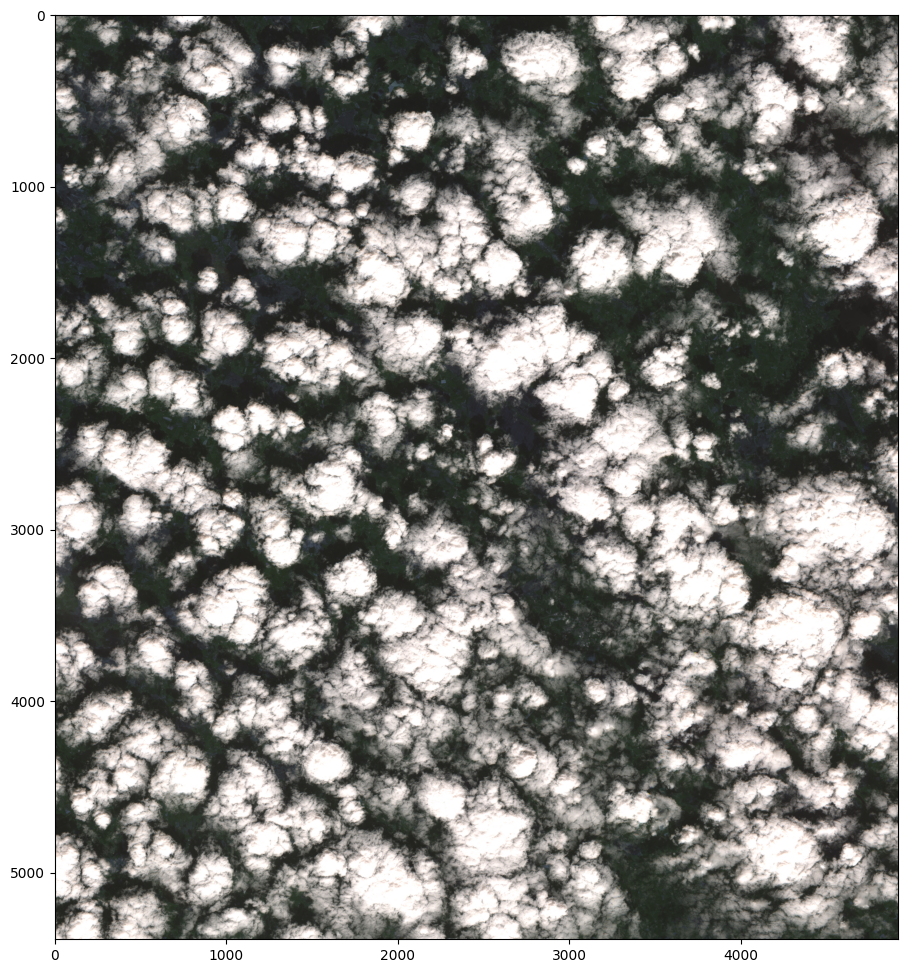

In [560]:
plt.imshow(np.clip(rgb, 0, 1))
plt.gcf().set_size_inches(12, 12)